In [3]:
# !pip install numpy pandas scikit-allel matplotlib
import gzip
import pandas as pd
from pandas_plink import read_plink
from sklearn.preprocessing import StandardScaler
import os
import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

In [4]:
# Load genotype data using pandas-plink
plink_file_prefix = '../data/1000G.EUR.1'  # Modify for other chromosomes if needed
(bim, fam, bed) = read_plink(plink_file_prefix)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 16.84it/s]


In [5]:
print(f"FAM file: \n{fam.head()}")

FAM file: 
       fid      iid father mother gender trait  i
0  HG00096  HG00096      0      0      0    -9  0
1  HG00097  HG00097      0      0      0    -9  1
2  HG00099  HG00099      0      0      0    -9  2
3  HG00101  HG00101      0      0      0    -9  3
4  HG00102  HG00102      0      0      0    -9  4


In [6]:
print(f"FAM file: \n{bim.head()}")

FAM file: 
  chrom        snp        cm     pos a0 a1  i
0     1  rs3094315  0.488776  752566  G  A  0
1     1  rs3131972  0.488868  752721  A  G  1
2     1  rs3131969  0.489734  754182  A  G  2
3     1  rs1048488  0.492507  760912  C  T  3
4     1  rs3115850  0.492605  761147  T  C  4


In [7]:
# Extract the sample IDs from the FAM file
genotype_sample_ids = fam['iid'].tolist()

In [8]:
# Load the gene expression sample IDs (similar to before)
gene_expression_file = '../data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt'

gene_expression_data = pd.read_csv(gene_expression_file, sep='\t')

In [9]:
gene_expression_data.head(10)

TargetID         Gene_Symbol Chr      Coord    HG00096  \
0   ENSG00000152931.6   ENSG00000152931.6   5   59783540   0.101858   
1   ENSG00000183696.9   ENSG00000183696.9   7   48128225   8.183805   
2   ENSG00000139269.2   ENSG00000139269.2  12   57846106   1.199910   
3   ENSG00000169129.8   ENSG00000169129.8  10  116164515   0.831940   
4  ENSG00000134602.11  ENSG00000134602.11   X  131157293  27.646422   
5  ENSG00000136237.12  ENSG00000136237.12   7   22396763   3.788503   
6   ENSG00000259425.1   ENSG00000259425.1  15   23096869   0.054059   
7   ENSG00000242284.2   ENSG00000242284.2   X  134953994   0.351716   
8   ENSG00000235027.1   ENSG00000235027.1  11    1781578   0.200791   
9   ENSG00000228169.3   ENSG00000228169.3  10  116450393  96.182178   

      HG00097    HG00099     HG00100     HG00101     HG00102  ...     NA20810  \
0    0.078110   0.048981    0.118597    0.004035    0.010925  ...    0.088601   
1    5.686911   2.434653    3.830894    6.612288    4.709646  ...   13.428205   
2    1.573572   0.521616    1.447225    3.565791    1.982681  ...    3.225880   
3    0.069778   0.931086    0.620941    1.660668    0.570481  ...    1.023381   
4   24.395572  16.445374   24.806650   25.113349   19.233988  ...   25.079490   
5    2.050963   4.000313    3.271619    1.798216    1.516688  ...    2.909393   
6    0.112185   0.003592    0.000500    0.029398    0.031266  ...    0.022056   
7    0.444540   0.227708    0.714112    0.450912    0.491438  ...    0.816645   
8    0.190138   0.092925    0.108790    0.232448    0.250905  ...    0.221223   
9  101.179262  58.783063  105.483527  105.818192  136.140843  ...  107.094412   

      NA20811    NA20812     NA20813     NA20814     NA20815    NA20816  \
0    0.240010   0.137175    0.148494    0.038643    0.088509   0.029204   
1    6.094500  12.536000    2.217262    3.573394    7.583364   4.052882   
2    1.996067   2.854923    2.267343    1.331201    2.187895   1.004250   
3    1.127852   0.774409    1.495854    0.895342    1.513521   0.826377   
4   28.725528  24.450520   27.264069   26.912814   29.509210  26.462331   
5    1.921176   5.083873    2.866573    1.297788    2.888316   2.145022   
6    0.010224   0.000204    0.059104    0.066048    0.013943   0.081050   
7    1.682329   0.686780    1.207540    0.088764    0.962397   0.053560   
8    0.254004   0.294359    0.172155    0.135213    0.121265   0.207399   
9  103.412712  81.928224  106.792474  100.898778  100.945145  94.643402   

      NA20819    NA20826     NA20828  
0    0.024423   0.044816    0.139186  
1    1.570378   4.900372    6.737308  
2    3.003316   1.984362    1.684954  
3    1.021201   0.952502    0.740565  
4   25.624009  25.707741   22.824957  
5    3.557598   4.152063    1.216834  
6    0.070438   0.049859    0.017376  
7   -0.099780   0.447343    0.002862  
8    0.288634   0.125602    0.141499  
9  114.259370  96.073384  105.326429  

[10 rows x 466 columns]

In [10]:
#Extract sample IDs from the gene expression data (column headers)
gene_expression_sample_ids = list(gene_expression_data.columns[4:])  # Starts from the 5th column onward

In [11]:
#Match the sample IDs between the two datasets
matched_sample_ids = set(gene_expression_sample_ids).intersection(set(genotype_sample_ids))


In [12]:
len(matched_sample_ids)

344

In [13]:
# Load gene annotation file (gene_annot.txt.gz)
gene_annotation_file = '../data/gene_annot.txt'
gene_annot = pd.read_csv(gene_annotation_file, sep='\t')


In [14]:
gene_annot

ID  CHR     START      STOP              SYM  \
0        DDX11L1    1     11868     13052  ENSG00000223972   
1          OR4F5    1     69090     70008  ENSG00000186092   
2         FAM87B    1    817370    819834  ENSG00000177757   
3      LINC00115    1    826205    827522  ENSG00000225880   
4      LINC01128    1    827607    859446  ENSG00000228794   
...          ...  ...       ...       ...              ...   
20495       ARSA   22  50622753  50628179  ENSG00000100299   
20496     SHANK3   22  50674414  50733298  ENSG00000251322   
20497        ACR   22  50738195  50745334  ENSG00000100312   
20498  RPL23AP82   22  50756947  50801309  ENSG00000184319   
20499     RABL2B   22  50767500  50783663  ENSG00000079974   

                                     TYPE  
0      transcribed_unprocessed_pseudogene  
1                          protein_coding  
2                                 lincRNA  
3                                 lincRNA  
4                    processed_transcript  
...                                   ...  
20495                      protein_coding  
20496                      protein_coding  
20497                      protein_coding  
20498  transcribed_unprocessed_pseudogene  
20499                      protein_coding  

[20500 rows x 6 columns]

In [15]:
# Select a gene  'RABL2B'
gene_of_interest = gene_annot[gene_annot['ID'] == 'FLVCR1-AS1']


In [16]:
# Extract the coordinates
chr_num = gene_of_interest['CHR'].values[0]  # chromosome
start = gene_of_interest['START'].values[0]  # transcription start site
end = gene_of_interest['STOP'].values[0]  # transcription end site


In [17]:
# Define the ± 500 kb window around the gene
window_start = max(0, start - 500000)
window_end = end + 500000


In [18]:
# Print coordinates 
print(f"{chr_num} {window_start} {window_end}")


1 212352107 213358088


./plink --bfile /Users/nancyh/Desktop/hartwell/TWAS/LDREF/1000G.EUR.1 \
       --extract range /Users/nancyh/Desktop/hartwell/capstone/my_coord.txt \
       --out /Users/nancyh/Desktop/hartwell/capstone/1000G.EUR.1.LINC01128 \
       --make-bed



# eQTL

In [19]:
# Load PLINK genotype data
plink_file_prefix = '../data/1000G.EUR.1.FLVCR1-AS1'  # Modify this path if needed
(bim_lin, fam_lin, bed_lin) = read_plink(plink_file_prefix)


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 101.30it/s]


In [20]:
bim_lin

chrom         snp         cm        pos a0 a1    i
0       1  rs17719838  234.51075  212353818  T  C    0
1       1  rs12039815  234.51139  212355971  T  C    1
2       1  rs11119872  234.51148  212356311  T  C    2
3       1  rs11119873  234.51165  212357001  A  G    3
4       1  rs11119874  234.51165  212357017  A  C    4
..    ...         ...        ...        ... .. ..  ...
437     1   rs6700169  235.26427  213337122  G  A  437
438     1   rs7517229  235.26430  213340377  G  A  438
439     1  rs12136981  235.26434  213345401  A  G  439
440     1   rs6702225  235.26435  213346508  C  A  440
441     1  rs10864038  235.26436  213348514  T  C  441

[442 rows x 7 columns]

In [21]:
print(f"Genotype matrix shape: {bed_lin.shape}")
print(f"FAM file shape: {fam_lin.shape}")


Genotype matrix shape: (442, 489)
FAM file shape: (489, 7)


In [22]:
# Split by '.' and take the first part
gene_expression_data['Gene_Symbol'] = gene_expression_data['Gene_Symbol'].str.split('.').str[0]

# Filter for the gene of interest in gene expression data (using the symbol)
expression_values = gene_expression_data[gene_expression_data['Gene_Symbol'] == gene_of_interest['SYM'].values[0]]  # Replace with LINC01128's correct ENSG ID


In [23]:
expression_values

TargetID      Gene_Symbol Chr      Coord   HG00096   HG00097  \
373  ENSG00000198468.2  ENSG00000198468   1  213031430  2.012264  1.063287   

      HG00099  HG00100   HG00101  HG00102  ...   NA20810   NA20811   NA20812  \
373  4.521263  1.88511  5.708887  4.05893  ...  6.706222  5.658657  6.697826   

      NA20813   NA20814  NA20815   NA20816   NA20819   NA20826   NA20828  
373  8.072564  6.508942  1.76569  4.199456  6.408672  5.207069  4.350987  

[1 rows x 466 columns]

In [24]:
# Gene expression sample columns (excluding the metadata columns)
expression_sample_ids = gene_expression_data.columns[4:]  # Adjust if necessary
expression_sample_ids

Index(['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102',
       'HG00103', 'HG00104', 'HG00105', 'HG00106',
       ...
       'NA20810', 'NA20811', 'NA20812', 'NA20813', 'NA20814', 'NA20815',
       'NA20816', 'NA20819', 'NA20826', 'NA20828'],
      dtype='object', length=462)

In [25]:
# Get the sample IDs from the .fam file
fam_lin_sample_ids = fam_lin['iid'].tolist()

In [26]:
common_sample_ids = [sid for sid in expression_sample_ids if sid in genotype_sample_ids]

# Get the indices of the common samples in the genotype matrix
common_sample_indices = [genotype_sample_ids.index(sid) for sid in common_sample_ids]

# Filter genotype matrix for common samples (489 individuals and 185 SNPs)
genotype_matrix = bed_lin.compute()[:, common_sample_indices]  # Filter genotype matrix based on common samples


In [27]:

# Filter gene expression values for the same common samples
y = expression_values[common_sample_ids].values.flatten()


In [28]:
# Make sure the genotype matrix has the shape (489, 185) where rows are samples and columns are SNPs
print(f"Filtered genotype matrix shape: {genotype_matrix.shape}")


Filtered genotype matrix shape: (442, 344)


In [29]:
from scipy import stats

# Initialize results list to store regression results
results = []

# Each row of genotype_matrix is a SNP, and each column corresponds to a sample
# Perform linear regression for each SNP (185 rows)
for i in range(genotype_matrix.shape[0]):  # Loop through SNPs (rows)
    X = genotype_matrix[i, :].reshape(-1, 1)  # SNP genotypes for all individuals (344 samples)
    
    # Perform linear regression (X: SNP genotypes, y: gene expression values)
    model = LinearRegression()
    model.fit(X, y)  # y contains gene expression values for the 344 samples
    
    # Get the coefficients and other statistics
    beta = model.coef_[0]
    r_squared = model.score(X, y)
    # Calculate residuals and standard error of the coefficient
    y_pred = model.predict(X)
    residuals = y - y_pred
    residual_sum_of_squares = np.sum(residuals**2)
    standard_error = np.sqrt(residual_sum_of_squares / (X.shape[0] - 2)) / np.sqrt(np.sum((X - np.mean(X))**2))
    
    # Calculate t-statistic and p-value
    t_statistic = beta / standard_error
    p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=X.shape[0] - 2))
    #p_value = 1 - r_squared  # Placeholder for p-value calculation (use statsmodels for actual p-value)

    # Append results
    results.append({
        'SNP': bim_lin['snp'][i],  # SNP ID from the BIM file (for each row in genotype_matrix)
        'Beta': beta,
        'R-Squared': r_squared,
        'P-Value': p_value
    })

# Convert results to DataFrame 
results_df = pd.DataFrame(results)
print(results_df.head())

          SNP      Beta  R-Squared   P-Value
0  rs17719838 -0.066682   0.000163  0.813370
1  rs12039815 -0.102068   0.000572  0.658505
2  rs11119872  0.535290   0.003846  0.251291
3  rs11119873 -0.584682   0.002101  0.396705
4  rs11119874 -0.292586   0.002792  0.328538


In [30]:
# Assuming bim_lin is your BIM file DataFrame containing 'snp', 'chrom', and 'pos'
# Merge results_df with the BIM file to get genomic coordinates (chromosome and base-pair position)
results_df = pd.merge(results_df, bim_lin[['snp', 'chrom', 'pos']], left_on='SNP', right_on='snp')

# Now, print the updated DataFrame to confirm the merge
print(results_df.head())


          SNP      Beta  R-Squared   P-Value         snp chrom        pos
0  rs17719838 -0.066682   0.000163  0.813370  rs17719838     1  212353818
1  rs12039815 -0.102068   0.000572  0.658505  rs12039815     1  212355971
2  rs11119872  0.535290   0.003846  0.251291  rs11119872     1  212356311
3  rs11119873 -0.584682   0.002101  0.396705  rs11119873     1  212357001
4  rs11119874 -0.292586   0.002792  0.328538  rs11119874     1  212357017


In [33]:
results_df

SNP      Beta  R-Squared   P-Value         snp chrom        pos
0    rs17719838 -0.066682   0.000163  0.813370  rs17719838     1  212353818
1    rs12039815 -0.102068   0.000572  0.658505  rs12039815     1  212355971
2    rs11119872  0.535290   0.003846  0.251291  rs11119872     1  212356311
3    rs11119873 -0.584682   0.002101  0.396705  rs11119873     1  212357001
4    rs11119874 -0.292586   0.002792  0.328538  rs11119874     1  212357017
..          ...       ...        ...       ...         ...   ...        ...
437   rs6700169 -0.116130   0.000568  0.659588   rs6700169     1  213337122
438   rs7517229 -0.128166   0.000783  0.604958   rs7517229     1  213340377
439  rs12136981 -0.662942   0.006440  0.137430  rs12136981     1  213345401
440   rs6702225  1.249582   0.014380  0.026147   rs6702225     1  213346508
441  rs10864038 -0.116130   0.000568  0.659588  rs10864038     1  213348514

[442 rows x 7 columns]

/Users/nancyh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


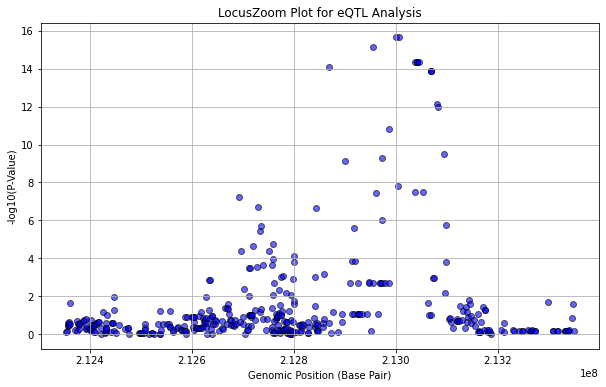

In [31]:
# Convert P-values to -log10(p-values)
results_df['-log10(P-Value)'] = -np.log10(results_df['P-Value'])

# Plot the LocusZoom plot: -log10(P-Value) vs BP (genomic position)
plt.figure(figsize=(10, 6))
plt.scatter(results_df['pos'], results_df['-log10(P-Value)'], c='blue', alpha=0.6, edgecolor='k')

# Add plot labels and title
plt.title('LocusZoom Plot for eQTL Analysis')
plt.xlabel('Genomic Position (Base Pair)')
plt.ylabel('-log10(P-Value)')
plt.grid(True)

# Display the plot
plt.show()

In [32]:
results_df[results_df['-log10(P-Value)']>0.008]

SNP      Beta  R-Squared   P-Value         snp chrom        pos  \
0    rs17719838 -0.066682   0.000163  0.813370  rs17719838     1  212353818   
1    rs12039815 -0.102068   0.000572  0.658505  rs12039815     1  212355971   
2    rs11119872  0.535290   0.003846  0.251291  rs11119872     1  212356311   
3    rs11119873 -0.584682   0.002101  0.396705  rs11119873     1  212357001   
4    rs11119874 -0.292586   0.002792  0.328538  rs11119874     1  212357017   
..          ...       ...        ...       ...         ...   ...        ...   
437   rs6700169 -0.116130   0.000568  0.659588   rs6700169     1  213337122   
438   rs7517229 -0.128166   0.000783  0.604958   rs7517229     1  213340377   
439  rs12136981 -0.662942   0.006440  0.137430  rs12136981     1  213345401   
440   rs6702225  1.249582   0.014380  0.026147   rs6702225     1  213346508   
441  rs10864038 -0.116130   0.000568  0.659588  rs10864038     1  213348514   

     -log10(P-Value)  
0           0.089712  
1           0.181441  
2           0.599823  
3           0.401532  
4           0.483414  
..               ...  
437         0.180727  
438         0.218275  
439         0.861918  
440         1.582584  
441         0.180727  

[437 rows x 8 columns]

In [33]:
results_df['P-Value'].min()

0.0

# Scale UP cis-eQTL

In [34]:
# Select chromosome of interest, e.g., chromosome 1
chromosome_of_interest = 1
genes_on_chrom = gene_annot[gene_annot['CHR'] == chromosome_of_interest]

# Define ±500 kb windows for each gene
genes_on_chrom['window_start'] = genes_on_chrom['START'].apply(lambda x: max(0, x - 500000))
genes_on_chrom['window_end'] = genes_on_chrom['STOP'] + 500000

/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_12670/549971436.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes_on_chrom['window_start'] = genes_on_chrom['START'].apply(lambda x: max(0, x - 500000))
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_12670/549971436.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes_on_chrom['window_end'] = genes_on_chrom['STOP'] + 500000


In [35]:
genes_on_chrom

ID  CHR      START       STOP              SYM  \
0       DDX11L1    1      11868      13052  ENSG00000223972   
1         OR4F5    1      69090      70008  ENSG00000186092   
2        FAM87B    1     817370     819834  ENSG00000177757   
3     LINC00115    1     826205     827522  ENSG00000225880   
4     LINC01128    1     827607     859446  ENSG00000228794   
...         ...  ...        ...        ...              ...   
2139    SH3BP5L    1  248810448  248826633  ENSG00000175137   
2140    MIR3124    1  248826376  248826443  ENSG00000264500   
2141     ZNF672    1  248838209  248849517  ENSG00000171161   
2142     ZNF692    1  248850005  248859085  ENSG00000171163   
2143      PGBD2    1  248906195  248919946  ENSG00000185220   

                                    TYPE  window_start  window_end  
0     transcribed_unprocessed_pseudogene             0      513052  
1                         protein_coding             0      570008  
2                                lincRNA        317370     1319834  
3                                lincRNA        326205     1327522  
4                   processed_transcript        327607     1359446  
...                                  ...           ...         ...  
2139                      protein_coding     248310448   249326633  
2140                               miRNA     248326376   249326443  
2141                      protein_coding     248338209   249349517  
2142                      protein_coding     248350005   249359085  
2143                      protein_coding     248406195   249419946  

[2144 rows x 8 columns]

In [38]:
import os

plink_file_prefix = '../data/1000G.EUR.1'
output_dir = '../output'

# Initialize a list to store genes with no SNPs in the range
skip_genes = []

# Loop over each gene and create a PLINK input file
for index, row in genes_on_chrom.iterrows():
    gene_name = row['ID']
    chr_num = row['CHR']
    window_start = row['window_start']
    window_end = row['window_end']
    
    # Create coordinate file for PLINK
    coord_file = os.path.join(output_dir, f"{gene_name}_coord.txt")
    with open(coord_file, 'w') as f:
        f.write(f"{chr_num} {window_start} {window_end} {gene_name}\n")
    
    # Define PLINK command and output prefix
    plink_output_prefix = os.path.join(output_dir, f"1000G.EUR.1.{gene_name}")
    plink_command = f"../plink/./plink --bfile {plink_file_prefix} --extract range {coord_file} --out {plink_output_prefix} --make-bed"
    
    # Run PLINK command and capture the output
    result = os.system(plink_command)
    
    # Check if PLINK generated the output files
    bed_file = f"{plink_output_prefix}.bed"
    if not os.path.exists(bed_file):
        # Add gene to skip list if no SNPs were extracted
        print(f"No SNPs found for gene {gene_name} in range {window_start}-{window_end}. Skipping this gene.")
        skip_genes.append(gene_name)
    else:
        print(f"SNPs extracted successfully for gene {gene_name}.")


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/1000G.EUR.1.DDX11L1.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract range ../output/DDX11L1_coord.txt
  --make-bed
  --out ../output/1000G.EUR.1.DDX11L1

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/1000G.EUR.1.DDX11L1.nosex .
No SNPs found for gene DDX11L1 in range 0-513052. Skipping this gene.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/1000G.EUR.1.OR4F5.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract range ../output/OR4F5_coord.txt
  --make-bed
  --out ../output/1000G.EUR.1.OR4F5

163

Error: All variants excluded by '--extract range'.
Error: All variants excluded by '--extract range'.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/1000G.EUR.1.LINC01128.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract range ../output/LINC01128_coord.txt
  --make-bed
  --out ../output/1000G.EUR.1.LINC01128

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/1000G.EUR.1.LINC01128.nosex .
--extract range: 98457 variants excluded.
--extract range: 185 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293

Error: All variants excluded by '--extract range'.
Error: All variants excluded by '--extract range'.
Error: All variants excluded by '--extract range'.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/1000G.EUR.1.FAM72D.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract range ../output/FAM72D_coord.txt
  --make-bed
  --out ../output/1000G.EUR.1.FAM72D

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/1000G.EUR.1.FAM72D.nosex .
No SNPs found for gene FAM72D in range 143455290-144471989. Skipping this gene.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/1000G.EUR.1.GPR89A.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract range ../output/GPR89A_coord.txt
  --make-bed
  --out ../output/1000G.EUR.1.GP

Error: All variants excluded by '--extract range'.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/1000G.EUR.1.POLR3C.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract range ../output/POLR3C_coord.txt
  --make-bed
  --out ../output/1000G.EUR.1.POLR3C

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/1000G.EUR.1.POLR3C.nosex .
--extract range: 98531 variants excluded.
--extract range: 111 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 

Error: All variants excluded by '--extract range'.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/1000G.EUR.1.FCGR1A.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract range ../output/FCGR1A_coord.txt
  --make-bed
  --out ../output/1000G.EUR.1.FCGR1A

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/1000G.EUR.1.FCGR1A.nosex .
--extract range: 98528 variants excluded.
--extract range: 114 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 

In [40]:
# Placeholder to store results for all genes
all_results = []

for index, row in genes_on_chrom.iterrows():
    gene_name = row['ID']
    # Skip genes with no SNPs
    if gene_name in skip_genes:
        continue

    ens_id = row['SYM']
    
    # Load PLINK genotype data for this gene
    plink_file_prefix = os.path.join(output_dir, f"1000G.EUR.1.{gene_name}")
    (bim, fam, bed) = read_plink(plink_file_prefix)
    
    # Filter gene expression for the gene of interest
    if sum(gene_expression_data['Gene_Symbol'] == ens_id) == 0:
        continue
    expression_values = gene_expression_data[gene_expression_data['Gene_Symbol'] == ens_id]
    
    # Get common samples between gene expression and genotype data
    expression_sample_ids = gene_expression_data.columns[4:]
    genotype_sample_ids = fam['iid'].tolist()
    common_sample_ids = [sid for sid in expression_sample_ids if sid in genotype_sample_ids]
    common_sample_indices = [genotype_sample_ids.index(sid) for sid in common_sample_ids]
    
    # Filter genotype matrix and gene expression values for common samples
    genotype_matrix = bed.compute()[:, common_sample_indices]
    y = expression_values[common_sample_ids].values.flatten()
    
    # Perform linear regression for each SNP and store results
    for i in range(genotype_matrix.shape[0]):  # Loop through SNPs (rows)
        X = genotype_matrix[i, :].reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, y)
        
        beta = model.coef_[0]
        r_squared = model.score(X, y)

        # Calculate residuals and standard error of the coefficient
        y_pred = model.predict(X)
        residuals = y - y_pred
        residual_sum_of_squares = np.sum(residuals**2)
        standard_error = np.sqrt(residual_sum_of_squares / (X.shape[0] - 2)) / np.sqrt(np.sum((X - np.mean(X))**2))
        
        # Calculate t-statistic and p-value
        t_statistic = beta / standard_error
        p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=X.shape[0] - 2))
 
        
        # Append results for this SNP
        all_results.append({
            'Gene': gene_name,
            'SNP': bim['snp'][i],
            'CHR': bim['chrom'][i],
            'BP': bim['pos'][i],
            'Beta': beta,
            'R-Squared': r_squared,
            'P-Value': p_value
        })

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 126.57it/s]
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_12670/2911360141.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  standard_error = np.sqrt(residual_sum_of_squares / (X.shape[0] - 2)) / np.sqrt(np.sum((X - np.mean(X))**2))
Mapping files: 100%|██████████| 3/3 [00:00<00:00, 127.91it/s]
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_12670/2911360141.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  standard_error = np.sqrt(residual_sum_of_squares / (X.shape[0] - 2)) / np.sqrt(np.sum((X - np.mean(X))**2))
Mapping files: 100%|██████████| 3/3 [00:00<00:00, 127.58it/s]
/var/folders/w6/bg9y2v016jx0q_g3bk713y100000gn/T/ipykernel_12670/2911360141.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  standard_error = np.sqrt(residual_sum_of_squares / (X.shape[0] - 2)) / np.sqrt(np.sum((X - np.mean(X))**2))
Mapping files: 100%|██████████| 3/3 [00:00<00:00, 12

In [41]:
# Convert to DataFrame
all_results_df = pd.DataFrame(all_results)
all_results_df

Gene         SNP CHR         BP      Beta  R-Squared       P-Value
0       FAM87B   rs3094315   1     752566 -0.046613   0.072917  3.678630e-07
1       FAM87B   rs3131972   1     752721 -0.045127   0.068567  8.428247e-07
2       FAM87B   rs3131969   1     754182  0.002844   0.000243  7.731408e-01
3       FAM87B   rs1048488   1     760912 -0.045292   0.070341  6.012103e-07
4       FAM87B   rs3115850   1     761147 -0.045504   0.071233  5.071800e-07
...        ...         ...  ..        ...       ...        ...           ...
674175   PGBD2   rs4926502   1  249209140  0.148219   0.009381  7.280190e-02
674176   PGBD2   rs6704311   1  249210707 -0.017717   0.000391  7.147619e-01
674177   PGBD2  rs34013644   1  249211350 -0.011718   0.000130  8.328615e-01
674178   PGBD2  rs12746903   1  249218992 -0.099312   0.001828  4.292437e-01
674179   PGBD2  rs12726733   1  249222473 -0.009268   0.000056  8.897415e-01

[674180 rows x 7 columns]

In [42]:
all_results_df.sort_values(by='P-Value') 

Gene         SNP CHR         BP      Beta     R-Squared  P-Value
211870     NSUN4   rs6429599   1   46827871  3.039063  3.478845e-01      0.0
154602  C1orf216   rs7530222   1   36200778  0.846743  1.964685e-01      0.0
263216   SLC44A5   rs2799050   1   75912000 -0.347027  2.067676e-01      0.0
212177      FAAH      rs9865   1   46827456 -0.361494  1.908544e-01      0.0
263215   SLC44A5   rs2587031   1   75911769 -0.347027  2.067676e-01      0.0
...          ...         ...  ..        ...       ...           ...      ...
628165     RAB4A  rs11805314   1  229611555  0.000000 -5.329071e-15      1.0
578196      CR1L   rs2782831   1  207557927  0.000000 -1.110223e-14      1.0
577438       CR2   rs2782831   1  207557927  0.000000 -3.241851e-14      1.0
577807       CR1   rs2782831   1  207557927  0.000000 -4.440892e-16      1.0
578943    PLXNA2   rs2782831   1  207557927  0.000000 -3.108624e-15      1.0

[674180 rows x 7 columns]

In [43]:
# Save to CSV
all_results_df.to_csv('../data/all_cis_eQTL_results.csv', index=False)
print(all_results_df.head())

     Gene        SNP CHR      BP      Beta  R-Squared       P-Value
0  FAM87B  rs3094315   1  752566 -0.046613   0.072917  3.678630e-07
1  FAM87B  rs3131972   1  752721 -0.045127   0.068567  8.428247e-07
2  FAM87B  rs3131969   1  754182  0.002844   0.000243  7.731408e-01
3  FAM87B  rs1048488   1  760912 -0.045292   0.070341  6.012103e-07
4  FAM87B  rs3115850   1  761147 -0.045504   0.071233  5.071800e-07


# PRS

In [44]:
# Load the BIM file
bim_file = '../data/1000G.EUR.1.bim' 
bim_df = pd.read_csv(bim_file, delim_whitespace=True, header=None, names=['CHR', 'SNP', 'GD', 'BP', 'A1', 'A0'])

# Keep only relevant columns: SNP and A0 (reference allele)
bim_df = bim_df[['SNP', 'A0']]

In [45]:
bim_df.head()

SNP A0
0  rs3094315  A
1  rs3131972  G
2  rs3131969  G
3  rs1048488  T
4  rs3115850  C

In [46]:
# Load the summary statistics
summary_stats_file = '../data/all_cis_eQTL_results.csv'  # Adjust to your file path
summary_stats = pd.read_csv(summary_stats_file)

summary_stats = summary_stats[summary_stats['Gene']=='FLVCR1-AS1']

summary_stats.rename(columns={'P-Value':'P', 'Beta':"BETA"}, inplace=True)

# Filter out rows with P-value equal to 1
summary_stats = summary_stats[summary_stats['P'] < 1]

# Keep only necessary columns (SNP, P-value, BETA)
summary_stats = summary_stats[['SNP', 'P', 'BETA']]
# Merge the A0 allele from the BIM file into the summary statistics
summary_stats = pd.merge(summary_stats, bim_df, on='SNP', how='inner')

summary_stats.head()

SNP         P      BETA A0
0  rs17719838  0.813370 -0.066682  C
1  rs12039815  0.658505 -0.102068  C
2  rs11119872  0.251291  0.535290  C
3  rs11119873  0.396705 -0.584682  G
4  rs11119874  0.328538 -0.292586  C

In [228]:
#a0 reference (REF) in 1kG

In [229]:
# # Save the transformed file for PLINK clumping
# summary_stats.to_csv('../data/eQTL_Results_Transformed.txt', sep='\t', index=False)


## Perform Clumping

In [47]:
# Define file paths
plink_path = "../plink/./plink"  # Path to PLINK executable
genotype_prefix = '../data/1000G.EUR.1'  # Adjust to your genotype file prefix (no extension)
summary_stats_file = "../data/eQTL_Results_Transformed.txt"  # Summary statistics file
output_prefix = "../output/clumped_results"  # Output prefix for clumped results

# Construct the PLINK command for clumping
plink_command = (
    f"{plink_path} "
    f"--bfile {genotype_prefix} "
    f"--clump {summary_stats_file} "
    f"--clump-p1 1 "
    f"--clump-r2 0.1 "
    f"--clump-kb 250 "
    f"--clump-snp-field SNP "
    f"--clump-field P "
    f"--out {output_prefix}"
)

# Run the PLINK command and capture the result
result = os.system(plink_command)

# Check if PLINK ran successfully
if result == 0:
    print("PLINK clumping completed successfully.")
else:
    print("PLINK clumping encountered an error.")


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/clumped_results.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --clump ../data/eQTL_Results_Transformed.txt
  --clump-field P
  --clump-kb 250
  --clump-p1 1
  --clump-r2 0.1
  --clump-snp-field SNP
  --out ../output/clumped_results

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/clumped_results.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total 

## Extract Valid SNPs After Clumping

In [48]:
# Define the path to the clumped file and output SNP list file
clumped_file = f"{output_prefix}.clumped"
valid_snps_file = f"{output_prefix}_valid_snps.txt"

# Extract the SNP IDs (3rd column) from the clumped file and save them
with open(clumped_file, 'r') as infile, open(valid_snps_file, 'w') as outfile:
    next(infile)  # Skip header
    for line in infile:
        parts = line.split()
        if len(parts) >= 3:  # Check if there are at least three columns
            snp_id = parts[2]  # SNP ID is in the third column
            outfile.write(f"{snp_id}\n")
        else:
            print(f"Skipping malformed line: {line.strip()}")

print(f"Valid SNPs saved to {valid_snps_file}")



Skipping malformed line: 
Skipping malformed line: 
Valid SNPs saved to ../output/clumped_results_valid_snps.txt


In [57]:
#Define the P-value thresholds file for PRS calculation
with open("../data/range_list", "w") as f:
    thresholds = [0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
    for t in thresholds:
        f.write(f"{t} 0 {t}\n")

### awk '{print $1,$2}' eQTL_Results_Transformed.txt > SNP.pvalue

In [58]:
# Construct the PLINK command for PRS calculation
prs_command = (
    f"{plink_path} "
    f"--bfile {genotype_prefix} "
    f"--score {summary_stats_file} 1 4 3 header "
    f"--q-score-range ../data/range_list ../data/SNP.pvalue "
    f"--extract {valid_snps_file} "
    f"--out ../output/PRS_results"
)

# Run PLINK command for PRS calculation
os.system(prs_command)


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/PRS_results.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract ../output/clumped_results_valid_snps.txt
  --out ../output/PRS_results
  --q-score-range ../data/range_list ../data/SNP.pvalue
  --score ../data/eQTL_Results_Transformed.txt 1 4 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/PRS_results.nosex .
--extract: 42 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787

due to allele code mismatch); see ../output/PRS_results.nopred for details.


0

In [59]:
# Load PRS results for a specific threshold (e.g., 0.05)
prs_file = '../output/PRS_results.0.5.profile'
prs_df = pd.read_csv(prs_file, delim_whitespace=True)

# View the PRS scores for each individual
print(prs_df.head())


       FID      IID  PHENO  CNT  CNT2     SCORE
0  HG00096  HG00096     -9   74    63  0.312895
1  HG00097  HG00097     -9   74    66  0.401610
2  HG00099  HG00099     -9   74    60  0.362638
3  HG00101  HG00101     -9   74    59  0.415545
4  HG00102  HG00102     -9   74    58  0.321205


# Cross-Val

In [66]:
# Define paths
plink_path = "../plink/./plink"
genotype_prefix = "../data/1000G.EUR.1"
summary_stats_file = "../data/eQTL_Results_Transformed.txt"
output_prefix = "../output/clumped_results"


# Load FAM file to sample individual IDs
fam_file = '../data/1000G.EUR.1.fam'
fam_df = pd.read_csv(fam_file, delim_whitespace=True, header=None, names=['FID', 'IID', 'PID', 'MID', 'Sex', 'Phenotype'])

# Extract the genotype sample IDs
genotype_sample_ids = set(fam_df['IID'])

# Filter expression data for the gene of interest
gene_expression = gene_expression_data[gene_expression_data['Gene_Symbol'] == gene_of_interest['SYM'].values[0]]
gene_expression = gene_expression.iloc[:, 4:]  # Select expression values only, remove metadata
gene_expression.columns = gene_expression.columns.str.strip()  # Remove any extra whitespace

# Get sample IDs from expression data (assuming columns start from the 5th position)
expression_sample_ids = set(gene_expression.columns)

In [67]:
# Get the intersection of sample IDs and filter datasets
common_sample_ids = genotype_sample_ids.intersection(expression_sample_ids)

filtered_fam_df = fam_df[fam_df['IID'].isin(common_sample_ids)]
filtered_expression_df = gene_expression[list(common_sample_ids)]

# Sample 80% for training
train_ids = filtered_fam_df.sample(frac=0.8, random_state=42)[['FID', 'IID']]
train_ids_file = '../output/train_ids.txt'
train_ids.to_csv(train_ids_file, sep=' ', index=False, header=False)

# Sample 10% of individuals for validation from the remaining 20%
remaining_20_ids = filtered_fam_df[~filtered_fam_df['IID'].isin(train_ids['IID'])]
validation_ids = remaining_20_ids.sample(frac=0.5, random_state=42)[['FID', 'IID']]
validation_ids_file = '../output/validation_ids.txt'
validation_ids.to_csv(validation_ids_file, sep=' ', index=False, header=False)

# Extract expression values for validation individuals
validation_expression = filtered_expression_df[validation_ids['IID']].iloc[0]



In [68]:
train_ids.head()

FID      IID
314  NA11894  NA11894
169  HG00373  HG00373
350  NA12400  NA12400
333  NA12154  NA12154
458  NA20790  NA20790

In [69]:
validation_ids.head()

FID      IID
131  HG00326  HG00326
1    HG00097  HG00097
379  NA12872  NA12872
37   HG00143  HG00143
399  NA20516  NA20516

In [70]:
plink_path

'../plink/./plink'

In [71]:
# Run clumping for each p-value and R^2 threshold on trainning set
# Define p-value thresholds
p_value_thresholds = [1, 0.05, 0.01, 0.001, 0.00001]
r2_thresholds = [0.1, 0.2, 0.5, 0.8]

for r2 in r2_thresholds:
    for threshold in p_value_thresholds:
        clump_output_prefix = f"{output_prefix}_p{threshold}_r2{r2}"
        clump_command = (
            f"{plink_path} --bfile {genotype_prefix} --clump {summary_stats_file} "
            f"--clump-p1 {threshold} "
            f"--clump-r2 {r2}  "
            f"--clump-snp-field SNP --clump-field P --keep {train_ids_file} --out {clump_output_prefix}"
        )
        
        # Run PLINK clumping command
        result = os.system(clump_command)
        if result == 0:
            print(f"Clumping completed successfully for p-value threshold {threshold} and r^2 threshold {r2}.")
        else:
            print(f"Clumping encountered an error for p-value threshold {threshold} and r^2 threshold {r2}.")
        
        # Extract SNP IDs from each clumped file
        clumped_file = f"{clump_output_prefix}.clumped"
        valid_snps_file = f"{clump_output_prefix}_valid_snps.txt"
        
        # Check if clumped file exists before proceeding
        if os.path.exists(clumped_file):
            with open(clumped_file, 'r') as infile, open(valid_snps_file, 'w') as outfile:
                next(infile)  # Skip header
                for line in infile:
                    parts = line.split()
                    if len(parts) >= 3:  # Ensure there are at least three columns
                        snp_id = parts[2]  # SNP ID is in the third column
                        outfile.write(f"{snp_id}\n")
            print(f"Valid SNPs for p-value threshold {threshold} and r^2 threshold {r2} saved to {valid_snps_file}")
        else:
            print(f"Warning: Clumped file not found for p-value threshold {threshold} and r^2 threshold {r2}.")

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/clumped_results_p1_r20.1.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --clump ../data/eQTL_Results_Transformed.txt
  --clump-field P
  --clump-p1 1
  --clump-r2 0.1
  --clump-snp-field SNP
  --keep ../output/train_ids.txt
  --out ../output/clumped_results_p1_r20.1

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/clumped_results_p1_r20.1.nosex .
--keep: 275 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 275 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686

In [72]:
clump_output_prefix

'../output/clumped_results_p1e-05_r20.8'

In [73]:
# Run PRS calculation for each threshold using the clumped SNPs and evaluate on validation set
r_squared_values = []

for r2 in r2_thresholds:
    for threshold in p_value_thresholds:
        # Define output for PRS calculation
        prs_output_prefix = f"{output_prefix}_{threshold}_r2{r2}"
        valid_snps_file = f"../output/clumped_results_p{threshold}_r2{r2}_valid_snps.txt"
        
        # Set up PLINK PRS calculation command for each threshold
        prs_command = (
            f"{plink_path} --bfile {genotype_prefix} --score {summary_stats_file} 1 4 3 header "
            f"--extract {valid_snps_file} --keep {validation_ids_file} "
            f"--out {prs_output_prefix}"
        )
        os.system(prs_command)
        
        # Load the predicted PRS values for correlation with true values
        prs_results_file = f"{prs_output_prefix}.profile"
        if not os.path.exists(prs_results_file):
            print(f"Warning: PRS results file not found for p-value threshold {threshold} and r² threshold {r2}. Skipping this threshold.")
            continue
        
        prs_results = pd.read_csv(prs_results_file, delim_whitespace=True)
        
        # Calculate R^2 between predicted and true expression values for validation individuals
        predicted_expression = prs_results['SCORE']
        correlation = np.corrcoef(predicted_expression, validation_expression)[0, 1]
        r_squared = correlation ** 2
        r_squared_values.append((threshold, r2, r_squared))
        print(f"R² for p-value threshold {threshold} and r² threshold {r2}: {r_squared}")


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/clumped_results_1_r20.1.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract ../output/clumped_results_p1_r20.1_valid_snps.txt
  --keep ../output/validation_ids.txt
  --out ../output/clumped_results_1_r20.1
  --score ../data/eQTL_Results_Transformed.txt 1 4 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/clumped_results_1_r20.1.nosex .
--extract: 41 variants remaining.
--keep: 34 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 34 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051

due to allele code mismatch); see ../output/clumped_results_1_r20.1.nopred for
details.
due to allele code mismatch); see ../output/clumped_results_0.05_r20.1.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_0.01_r20.1.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_0.001_r20.1.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/clumped_results_1e-05_r20.1.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract ../output/clumped_results_p1e-05_r20.1_valid_snps.txt
  --keep ../output/validation_ids.txt
  --out ../output/clumped_results_1e-05_r20.1
  --score ../data/eQTL_Results_Transformed.txt 1 4 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/clumped_results_1e-05_r20.1.nosex .
--extract: 4 variants remaining.
--keep: 34 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 34 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434

due to allele code mismatch); see ../output/clumped_results_1e-05_r20.1.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_1_r20.2.nopred for
details.
due to allele code mismatch); see ../output/clumped_results_0.05_r20.2.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_0.01_r20.2.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/clumped_results_0.001_r20.2.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract ../output/clumped_results_p0.001_r20.2_valid_snps.txt
  --keep ../output/validation_ids.txt
  --out ../output/clumped_results_0.001_r20.2
  --score ../data/eQTL_Results_Transformed.txt 1 4 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/clumped_results_0.001_r20.2.nosex .
--extract: 16 variants remaining.
--keep: 34 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 34 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243

due to allele code mismatch); see ../output/clumped_results_0.001_r20.2.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_1e-05_r20.2.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_1_r20.5.nopred for
details.
due to allele code mismatch); see ../output/clumped_results_0.05_r20.5.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/clumped_results_0.01_r20.5.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract ../output/clumped_results_p0.01_r20.5_valid_snps.txt
  --keep ../output/validation_ids.txt
  --out ../output/clumped_results_0.01_r20.5
  --score ../data/eQTL_Results_Transformed.txt 1 4 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/clumped_results_0.01_r20.5.nosex .
--extract: 35 variants remaining.
--keep: 34 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 34 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445

due to allele code mismatch); see ../output/clumped_results_0.01_r20.5.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_0.001_r20.5.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_1e-05_r20.5.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_1_r20.8.nopred for
details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../output/clumped_results_0.05_r20.8.log.
Options in effect:
  --bfile ../data/1000G.EUR.1
  --extract ../output/clumped_results_p0.05_r20.8_valid_snps.txt
  --keep ../output/validation_ids.txt
  --out ../output/clumped_results_0.05_r20.8
  --score ../data/eQTL_Results_Transformed.txt 1 4 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
98642 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../output/clumped_results_0.05_r20.8.nosex .
--extract: 69 variants remaining.
--keep: 34 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 34 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445

due to allele code mismatch); see ../output/clumped_results_0.05_r20.8.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_0.01_r20.8.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_0.001_r20.8.nopred
for details.
due to allele code mismatch); see ../output/clumped_results_1e-05_r20.8.nopred
for details.


In [74]:
# Directory where profile files are stored
output_prefix = "../output/clumped_results"

# Define p-value and r2 thresholds
p_value_thresholds = ["1", "0.05", "0.01", "0.001", "1e-05"]
r2_thresholds = ["0.1", "0.2", "0.5", "0.8"]

# Initialize a list to store R^2 results for each threshold combination
r_squared_results = []

# Loop through each p-value and r2 threshold, loading PRS and calculating R^2
for p_threshold in p_value_thresholds:
    for r2 in r2_thresholds:
        # Construct the path to the profile file
        profile_file = f"{output_prefix}_{p_threshold}_r2{r2}.profile"
        
        # Check if the file exists
        if os.path.exists(profile_file):
            # Load PRS results
            prs_results = pd.read_csv(profile_file, delim_whitespace=True)
            
            # Ensure PRS results contain 'SCORE' column
            if 'SCORE' in prs_results.columns:
                # Calculate correlation and R^2
                predicted_expression = prs_results['SCORE']
                correlation = np.corrcoef(predicted_expression, validation_expression)[0, 1]
                r_squared = correlation ** 2
                
                # Store the results with both thresholds
                r_squared_results.append((p_threshold, r2, r_squared))
            else:
                print(f"Warning: 'SCORE' column missing in {profile_file}")
        else:
            print(f"Warning: Profile file not found: {profile_file}")

# Convert results to DataFrame for easy analysis
r_squared_df = pd.DataFrame(r_squared_results, columns=['P_Threshold', 'R2_Threshold', 'R^2'])

# Check if r_squared_df is not empty to avoid errors
if not r_squared_df.empty:
    # Find the best combination of p-value and r2 threshold based on maximum R^2
    best_result = r_squared_df.loc[r_squared_df['R^2'].idxmax()]
    best_p_threshold = best_result['P_Threshold']
    best_r2_threshold = best_result['R2_Threshold']
    best_r_squared = best_result['R^2']

    print(f"Best p-value threshold: {best_p_threshold}, Best r2 threshold: {best_r2_threshold}, R^2: {best_r_squared}")
else:
    print("No valid R^2 results found. Please check input files.")


Best p-value threshold: 0.001, Best r2 threshold: 0.2, R^2: 0.09259211613591893


In [75]:
r_squared_df

P_Threshold R2_Threshold       R^2
0            1          0.1  0.067942
1            1          0.2  0.082864
2            1          0.5  0.075683
3            1          0.8  0.080637
4         0.05          0.1  0.063941
5         0.05          0.2  0.086107
6         0.05          0.5  0.070715
7         0.05          0.8  0.073800
8         0.01          0.1  0.060762
9         0.01          0.2  0.084743
10        0.01          0.5  0.075352
11        0.01          0.8  0.074715
12       0.001          0.1  0.061613
13       0.001          0.2  0.092592
14       0.001          0.5  0.073628
15       0.001          0.8  0.071804
16       1e-05          0.1  0.074566
17       1e-05          0.2  0.076576
18       1e-05          0.5  0.070029
19       1e-05          0.8  0.072742

In [76]:
prs_results

FID      IID  PHENO  CNT  CNT2     SCORE
0   HG00097  HG00097     -9   60    31  0.355523
1   HG00143  HG00143     -9   60    54  1.716430
2   HG00157  HG00157     -9   60    51  1.655770
3   HG00174  HG00174     -9   60    37  0.972969
4   HG00178  HG00178     -9   60    39  1.030820
5   HG00179  HG00179     -9   60    42  1.052420
6   HG00185  HG00185     -9   60    41  1.026200
7   HG00263  HG00263     -9   60    42  0.876846
8   HG00275  HG00275     -9   60    45  1.201080
9   HG00278  HG00278     -9   60    25  0.265468
10  HG00326  HG00326     -9   60    42  1.008930
11  HG00362  HG00362     -9   60    50  1.808970
12  HG00379  HG00379     -9   60    54  1.700640
13  HG01790  HG01790     -9   60    29  0.210531
14  NA06986  NA06986     -9   60    43  1.025420
15  NA11832  NA11832     -9   60    49  1.706090
16  NA11840  NA11840     -9   60    43  1.119310
17  NA11843  NA11843     -9   60    50  1.290010
18  NA12044  NA12044     -9   60    38  0.946173
19  NA12144  NA12144     -9   60    49  1.181890
20  NA12272  NA12272     -9   60    51  1.686840
21  NA12286  NA12286     -9   60    51  1.639980
22  NA12762  NA12762     -9   60    51  1.343790
23  NA12778  NA12778     -9   60    44  0.988519
24  NA12813  NA12813     -9   60    29  0.191162
25  NA12872  NA12872     -9   60    51  1.268940
26  NA20505  NA20505     -9   60    46  1.435660
27  NA20516  NA20516     -9   60    45  1.378320
28  NA20520  NA20520     -9   60    42  0.985720
29  NA20525  NA20525     -9   60    50  1.544800
30  NA20581  NA20581     -9   60    47  1.050390
31  NA20766  NA20766     -9   60    45  1.015410
32  NA20774  NA20774     -9   60    35  0.466330
33  NA20828  NA20828     -9   60    49  1.291750

# Predict genetic risk for different diseases

In [214]:
def predict_prs(disease_name, genotype_prefix, summary_stats_file, output_prefix, plink_path):
    # Perform Clumping
    print(f"Performing PLINK clumping for {disease_name}...")
    clumped_file = f"{output_prefix}.clumped"
    valid_snps_file = f"{output_prefix}_valid_snps.txt"
    plink_command = (
        f"{plink_path} "
        f"--bfile {genotype_prefix} "
        f"--clump {summary_stats_file} "
        f"--clump-p1 0.0001 "
        f"--clump-kb 250 "
        f"--clump-snp-field SNP "
        f"--clump-field P "
        f"--keep {genotype_prefix}.fam --out {output_prefix}"
    )
    os.system(plink_command)

    # Extract Valid SNPs
    print(f"Extracting valid SNPs from clumped results for {disease_name}...")
    if os.path.exists(clumped_file):
        with open(clumped_file, 'r') as infile, open(valid_snps_file, 'w') as outfile:
            next(infile)  # Skip the header line
            for line in infile:
                parts = line.split()
                if len(parts) >= 3:
                    snp_id = parts[2]  # SNP ID is in the 3rd column
                    outfile.write(f"{snp_id}\n")
        print(f"Valid SNPs saved to {valid_snps_file}")
    else:
        print(f"Error: Clumped file {clumped_file} not found.")
        return

    # Generate the PRS
    print(f"Calculating PRS for {disease_name}...")
    score_file = f"{output_prefix}_score_file.txt"
    prs_output_prefix = f"{output_prefix}_results"
    
    # Create a score file from summary statistics
    summary_stats = pd.read_csv(summary_stats_file, delim_whitespace=True)
    summary_stats = summary_stats[summary_stats['P'] < 1e-4]
    valid_snps = pd.read_csv(valid_snps_file, header=None, names=['SNP'])
    filtered_stats = summary_stats.merge(valid_snps, on='SNP', how='inner')
    filtered_stats[['SNP', 'A1', 'BETA']].to_csv(score_file, sep='\t', index=False, header=False)
    print(f"Score file saved to: {score_file}")
    # print(filtered_stats)

    # Calculate the PRS
    prs_command = (
        f"{plink_path} "
        f"--bfile {genotype_prefix} "
        f"--score {score_file} 1 2 3 header "
        f"--extract {valid_snps_file} --keep {genotype_prefix}.fam "
        f"--out {prs_output_prefix} "
    )
    os.system(prs_command)
    print(prs_output_prefix)

    # Load and Visualize PRS Results
    print(f"Loading and visualizing PRS results for {disease_name}...")
    prs_results_file = f"{prs_output_prefix}.profile"
    if not os.path.exists(prs_results_file):
        print(f"Error: PRS results file {prs_results_file} not found.")
        return

    prs_df = pd.read_csv(prs_results_file, delim_whitespace=True)
    # print(prs_df.head())
    print(f"PRS results loaded: {prs_df.shape[0]} individuals")

    tiffany_score = prs_df[prs_df['FID'] == 'FAM001']['SCORE'].values[0] if 'FAM001' in prs_df['FID'].values else None


    # Visualization
    plt.figure(figsize=(10, 6))
    plt.hist(prs_df['SCORE'], bins=50, alpha=0.7, label='Individuals')

    #  Calculate Tiffany's PRS percentile 
    if tiffany_score is not None:
        plt.axvline(tiffany_score, color='red', linestyle='dashed', linewidth=2, label="Tiffany's PRS")
        percentile = (prs_df['SCORE'] < tiffany_score).mean() * 100
        print(f"Tiffany's PRS percentile: {percentile:.2f}%")

        
    plt.xlabel('Polygenic Risk Score (PRS)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of PRS for {disease_name}')
    plt.legend()
    plt.grid(True)
    plt.show()




# Preprocess GWAS Summury Statistics

In [173]:
height = "../data/Height.gwas.txt"
height_gwas = pd.read_csv(height, sep='\t')
height_gwas['BETA'] = np.log(height_gwas['OR'])
height_gwas.head()

CHR      BP         SNP A1 A2       N        SE         P        OR  \
0    1  756604   rs3131962  A  G  388028  0.003017  0.483171  0.997887   
1    1  768448  rs12562034  A  G  388028  0.003295  0.834808  1.000687   
2    1  779322   rs4040617  G  A  388028  0.003033  0.428970  0.997604   
3    1  801536  rs79373928  G  T  388028  0.008413  0.808999  1.002036   
4    1  808631  rs11240779  G  A  388028  0.002428  0.590265  1.001308   

       INFO       MAF      BETA  
0  0.890558  0.369390 -0.002115  
1  0.895894  0.336846  0.000687  
2  0.897508  0.377368 -0.002399  
3  0.908963  0.483212  0.002034  
4  0.893213  0.450410  0.001307

In [175]:
height_gwas.to_csv("../data/processed_height.tsv", sep='\t', index=False)

In [209]:
# preprocess
conscientiousness = "../data/GPC-1.BigFiveNEO/GPC-1.NEO-conscientiousness.full.txt"
column_names = ['SNP', 'CHR', 'BP', 'A1', 'A2', 'BETA', 'SE', 'P', 'INFO', 'N', 'MAF']
conscientiousness_gwas = pd.read_csv(conscientiousness, sep='\t', names=column_names)
conscientiousness_gwas['A1']=conscientiousness_gwas['A1'].str.upper()
conscientiousness_gwas['A2']=conscientiousness_gwas['A2'].str.upper()
conscientiousness_gwas.head()

SNP  CHR       BP A1 A2    BETA      SE       P   INFO  N    MAF
0  rs3121561    1   980243  T  C -0.0144  0.1282  0.9105  0.531  8  0.267
1  rs3813193    1   988364  C  G  0.0469  0.1211  0.6985  0.782  9  0.150
2  rs3934834    1   995669  T  C  0.0759  0.1203  0.5282  0.900  9  0.119
3  rs3766193    1  1007033  C  G  0.0419  0.0918  0.6485  0.671  9  0.431
4  rs3766192    1  1007060  T  C -0.0514  0.0879  0.5586  0.777  9  0.424

In [210]:
conscientiousness_gwas.to_csv("../data/processed_conscientiousness.tsv", sep='\t', index=False)

In [201]:
# preprocess
extraversion = "../data/GPC-1.BigFiveNEO/GPC-1.NEO-EXTRAVERSION.full.txt"
column_names = ['SNP', 'CHR', 'BP', 'A1', 'A2', 'BETA', 'SE', 'P', 'INFO', 'N', 'MAF']

extraversion_gwas = pd.read_csv(extraversion, sep='\t', names=column_names)

extraversion_gwas['A1']=extraversion_gwas['A1'].str.upper()
extraversion_gwas['A2']=extraversion_gwas['A2'].str.upper()
extraversion_gwas.head()

SNP  CHR       BP A1 A2    BETA      SE       P   INFO  N    MAF
0  rs3121561    1   980243  T  C -0.0071  0.1350  0.9579  0.530  8  0.267
1  rs3813193    1   988364  C  G  0.0096  0.1269  0.9394  0.782  9  0.150
2  rs3934834    1   995669  T  C  0.0311  0.1261  0.8052  0.901  9  0.119
3  rs3766193    1  1007033  C  G  0.0075  0.0946  0.9365  0.672  9  0.431
4  rs3766192    1  1007060  T  C -0.0011  0.0907  0.9901  0.778  9  0.424

In [203]:
extraversion_gwas.to_csv("../data/processed_extraversion.tsv", sep='\t', index=False)

In [218]:
# preprocess
openness = "../data/GPC-1.BigFiveNEO/GPC-1.NEO-OPENNESS.full.txt"
column_names = ['SNP', 'CHR', 'BP', 'A1', 'A2', 'BETA', 'SE', 'P', 'INFO', 'N', 'MAF']
openness_gwas = pd.read_csv(openness, sep='\t', names=column_names)
openness_gwas['A1']=openness_gwas['A1'].str.upper()
openness_gwas['A2']=openness_gwas['A2'].str.upper()
openness_gwas.head()

SNP  CHR       BP A1 A2    BETA      SE       P   INFO  N    MAF
0  rs3121561    1   980243  T  C -0.0259  0.1199  0.8293  0.536  8  0.267
1  rs3813193    1   988364  C  G -0.0019  0.1144  0.9868  0.785  9  0.150
2  rs3934834    1   995669  T  C  0.0097  0.1139  0.9324  0.902  9  0.119
3  rs3766193    1  1007033  C  G  0.0512  0.0870  0.5560  0.673  9  0.431
4  rs3766192    1  1007060  T  C -0.0503  0.0831  0.5451  0.779  9  0.424

In [219]:
openness_gwas.to_csv("../data/processed_openness.tsv", sep='\t', index=False)

# Prediction

Performing PLINK clumping for Height...
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../prs_result/Height_PRS_tiffany.log.
Options in effect:
  --bfile ../data/merged_data
  --clump ../data/processed_height.tsv
  --clump-field P
  --clump-kb 250
  --clump-p1 0.0001
  --clump-snp-field SNP
  --keep ../data/merged_data.fam
  --out ../prs_result/Height_PRS_tiffany

16384 MB RAM detected; reserving 8192 MB for main workspace.
728323 variants loaded from .bim file.
490 people (0 males, 1 female, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../prs_result/Height_PRS_tiffany.nosex .
--keep: 490 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 490 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253

20591 more top variant IDs missing; see log file.


Score file saved to: ../prs_result/Height_PRS_tiffany_score_file.txt
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../prs_result/Height_PRS_tiffany_results.log.
Options in effect:
  --bfile ../data/merged_data
  --extract ../prs_result/Height_PRS_tiffany_valid_snps.txt
  --keep ../data/merged_data.fam
  --out ../prs_result/Height_PRS_tiffany_results
  --score ../prs_result/Height_PRS_tiffany_score_file.txt 1 2 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
728323 variants loaded from .bim file.
490 people (0 males, 1 female, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../prs_result/Height_PRS_tiffany_results.nosex .
--extract: 6595 variants remaining.
--keep: 490 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 490 founders and 0 nonfounders present.
Calculating allele f

due to allele code mismatch); see
../prs_result/Height_PRS_tiffany_results.nopred for details.


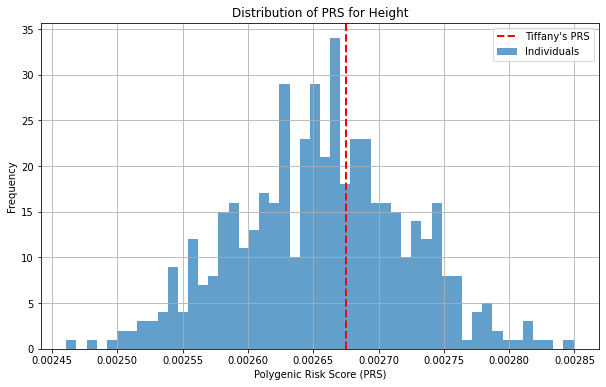

In [206]:

predict_prs(
    disease_name="Height",
    genotype_prefix="../data/merged_data",
    summary_stats_file="../data/processed_height.tsv",
    output_prefix="../prs_result/Height_PRS_tiffany",
    plink_path="../plink/./plink"
)


Performing PLINK clumping for Extraversion...
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../prs_result/Extraversion_PRS_tiffany.log.
Options in effect:
  --bfile ../data/merged_data
  --clump ../data/processed_extraversion.tsv
  --clump-field P
  --clump-kb 250
  --clump-p1 0.0001
  --clump-snp-field SNP
  --keep ../data/merged_data.fam
  --out ../prs_result/Extraversion_PRS_tiffany

16384 MB RAM detected; reserving 8192 MB for main workspace.
728323 variants loaded from .bim file.
490 people (0 males, 1 female, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../prs_result/Extraversion_PRS_tiffany.nosex .
--keep: 490 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 490 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738

188 more top variant IDs missing; see log file.


Score file saved to: ../prs_result/Extraversion_PRS_tiffany_score_file.txt
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../prs_result/Extraversion_PRS_tiffany_results.log.
Options in effect:
  --bfile ../data/merged_data
  --extract ../prs_result/Extraversion_PRS_tiffany_valid_snps.txt
  --keep ../data/merged_data.fam
  --out ../prs_result/Extraversion_PRS_tiffany_results
  --score ../prs_result/Extraversion_PRS_tiffany_score_file.txt 1 2 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
728323 variants loaded from .bim file.
490 people (0 males, 1 female, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
../prs_result/Extraversion_PRS_tiffany_results.nosex .
--extract: 17 variants remaining.
--keep: 490 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 490 founders and 0 nonfoun

to allele code mismatch); see
../prs_result/Extraversion_PRS_tiffany_results.nopred for details.


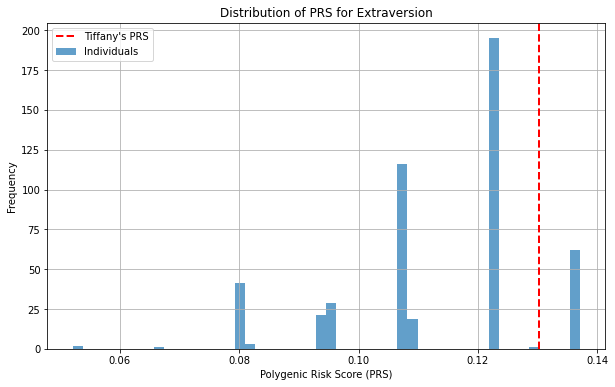

In [216]:

predict_prs(
    disease_name="Extraversion",
    genotype_prefix="../data/merged_data",
    summary_stats_file="../data/processed_extraversion.tsv",
    output_prefix="../prs_result/Extraversion_PRS_tiffany",
    plink_path="../plink/./plink"
)


Performing PLINK clumping for Openness...
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../prs_result/Openness_PRS_tiffany.log.
Options in effect:
  --bfile ../data/merged_data
  --clump ../data/processed_openness.tsv
  --clump-field P
  --clump-kb 250
  --clump-p1 0.0001
  --clump-snp-field SNP
  --keep ../data/merged_data.fam
  --out ../prs_result/Openness_PRS_tiffany

16384 MB RAM detected; reserving 8192 MB for main workspace.
728323 variants loaded from .bim file.
490 people (0 males, 1 female, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../prs_result/Openness_PRS_tiffany.nosex .
--keep: 490 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 490 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748

357 more top variant IDs missing; see log file.


Score file saved to: ../prs_result/Openness_PRS_tiffany_score_file.txt
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../prs_result/Openness_PRS_tiffany_results.log.
Options in effect:
  --bfile ../data/merged_data
  --extract ../prs_result/Openness_PRS_tiffany_valid_snps.txt
  --keep ../data/merged_data.fam
  --out ../prs_result/Openness_PRS_tiffany_results
  --score ../prs_result/Openness_PRS_tiffany_score_file.txt 1 2 3 header

16384 MB RAM detected; reserving 8192 MB for main workspace.
728323 variants loaded from .bim file.
490 people (0 males, 1 female, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ../prs_result/Openness_PRS_tiffany_results.nosex .
--extract: 25 variants remaining.
--keep: 490 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 490 founders and 0 nonfounders present.
Calculatin

to allele code mismatch); see ../prs_result/Openness_PRS_tiffany_results.nopred
for details.


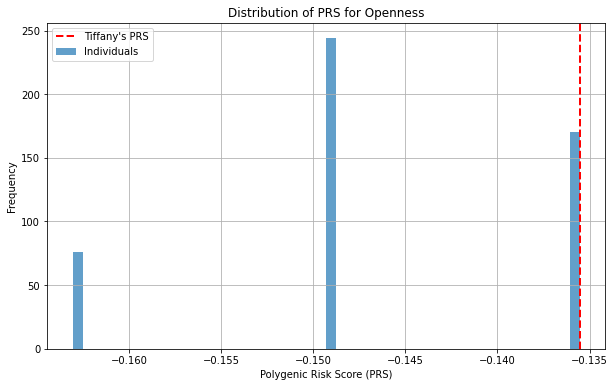

In [220]:

predict_prs(
    disease_name="Openness",
    genotype_prefix="../data/merged_data",
    summary_stats_file="../data/processed_openness.tsv",
    output_prefix="../prs_result/Openness_PRS_tiffany",
    plink_path="../plink/./plink"
)
